In [1]:
from fuzzyART_gai import *
from kit_handy import *
#import sklearn.datasets as ds
from kit_painting import *
import matplotlib.pyplot as plt
#import numpy.random as rnd

In [2]:
data, label_true = load_data('gaussian2d') # iris
pca_painter = PaintPCA(data)

Variance explained by first 2 principal components: [0.72092434 0.27907566]


dataset = 'gaussian' # 'iris'

if dataset == 'iris':
    iris = ds.load_iris()
    data = iris['data'] / np.max(iris['data'], axis=0)
    label_true = iris['target']
elif dataset == 'gaussian':
    labels = [0,1,2]
    catnum = len(labels)
    mean = rnd.uniform(size=(catnum,2))
    cov = [np.diag(d) for d in rnd.uniform(high=0.1, size=(catnum,2))]
    catsize = 50
    label_true = np.repeat(labels, catsize)
    data = np.empty((0, 2))
    for m, c in zip(mean, cov):
        raw = np.random.multivariate_normal(m, c, size=catsize)
        pos = np.abs(raw)
        data = np.append(data, pos, axis=0)

pca_painter = PaintPCA(data)

0.5
Category 4 is too small
Category 5 is too small
figure saved at _simcache/2022-04-01_11-06-41_var_rho50


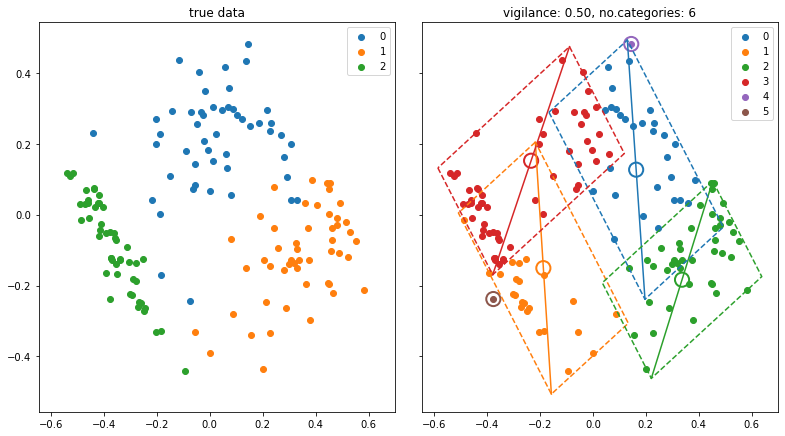

In [3]:
no_rho = 11
ls_rho = np.linspace(0, 1, no_rho)
fig, axs = plt.subplots(1, 2,
                        figsize = (11, 6), sharex=True, sharey=True)
fig.tight_layout()

# plot true data
pca_painter.scatter(axs[0], label_true)
axs[0].set_title("true data")

for rho in [.5]:#ls_rho: 
    print(rho)
    
    axs[1].clear()
    # init
    net = FuzzyARTgai(alpha=0.5, rho=rho)
    
    # train
    net.train(data, epochs=100) # each epoch, all data is shuffled
    label_pred = net.test(data).astype(int)

    # plot
    # pred
    pca_painter.scatter(axs[1], label_pred, data)
    
    # bipole and centre
    pca_painter.tripole(axs[1], *net.getcat_bipole())
    
    # boundary    
    axs[1].set_prop_cycle(None)
    pca_painter.boundary(axs[1], net.getcat_vertex())
    
    # info
    cat_number = net.w.shape[0]
    axs[1].set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))
    
    # save fig
    simname = 'var_rho{:d}'.format(int(rho*100))
    dirname = '_simcache'
    savefigure_datetime(fig, simname, dirname)
    
for ax in axs:
    ax.legend()